In [2]:
import pandas as pd
import matplotlib.pyplot as plt

In [3]:
input_df = pd.read_csv('/Users/pedro.josealvarez/Downloads/ISIC_2024_Training_Supplement.csv')
groundtruth_df = pd.read_csv('/Users/pedro.josealvarez/Downloads/ISIC_2024_Training_GroundTruth.csv')
metadata_df = pd.read_csv('/Users/pedro.josealvarez/Downloads/ISIC_2024_Training_Input/metadata.csv')

/var/folders/y3/5p875_qj2xd7p2f3rrbxxc5c0000gn/T/ipykernel_89871/4125996834.py:1: DtypeWarning: Columns (9) have mixed types. Specify dtype option on import or set low_memory=False.
  input_df = pd.read_csv('/Users/pedro.josealvarez/Downloads/ISIC_2024_Training_Supplement.csv')


---
## Metadata Pre-Processing


In [4]:
print(f'(pre-processing) # of images in dataset: {metadata_df.shape[0]}')
print(f'(pre-processing) # of features per image: {metadata_df.shape[1]}')
print(f'(pre-processing) # of duplicate image ids {metadata_df.shape[0] - metadata_df.isic_id.value_counts().count()}')
print(f'# of images with ground truth results: {100*groundtruth_df.shape[0]/metadata_df.shape[0]:.2f}%')
print(f'(from ground truth dataframe)avg. cancerous rate {100*groundtruth_df.malignant.mean():.2f}%')
print(f"\nMetadata columns:\n{metadata_df.columns}")


(pre-processing) # of images in dataset: 401059
(pre-processing) # of features per image: 42
(pre-processing) # of duplicate image ids 0
# of images with ground truth results: 100.00%
(from ground truth dataframe)avg. cancerous rate 0.10%

Metadata columns:
Index(['isic_id', 'patient_id', 'age_approx', 'sex', 'anatom_site_general',
       'clin_size_long_diam_mm', 'image_type', 'tbp_tile_type', 'tbp_lv_A',
       'tbp_lv_Aext', 'tbp_lv_B', 'tbp_lv_Bext', 'tbp_lv_C', 'tbp_lv_Cext',
       'tbp_lv_H', 'tbp_lv_Hext', 'tbp_lv_L', 'tbp_lv_Lext', 'tbp_lv_areaMM2',
       'tbp_lv_area_perim_ratio', 'tbp_lv_color_std_mean', 'tbp_lv_deltaA',
       'tbp_lv_deltaB', 'tbp_lv_deltaL', 'tbp_lv_deltaLB',
       'tbp_lv_deltaLBnorm', 'tbp_lv_eccentricity', 'tbp_lv_location',
       'tbp_lv_location_simple', 'tbp_lv_minorAxisMM',
       'tbp_lv_nevi_confidence', 'tbp_lv_norm_border', 'tbp_lv_norm_color',
       'tbp_lv_perimeterMM', 'tbp_lv_radial_color_std_max', 'tbp_lv_stdL',
       'tbp_lv_stdLExt'

In [5]:
metadata_df.isna().sum()
metadata_df_clean = metadata_df.dropna(subset=['age_approx', 'sex', 'anatom_site_general'])
print(f"Original size: {metadata_df.shape[0]}")
print(f"Cleaned size: {metadata_df_clean.shape[0]}")
print(f"Rows dropped: {metadata_df.shape[0] - metadata_df_clean.shape[0]}")

Original size: 401059
Cleaned size: 381914
Rows dropped: 19145


In [6]:
metadata_df = metadata_df_clean

---
#### EDA: Age Distribution & Cancerous Image Rate

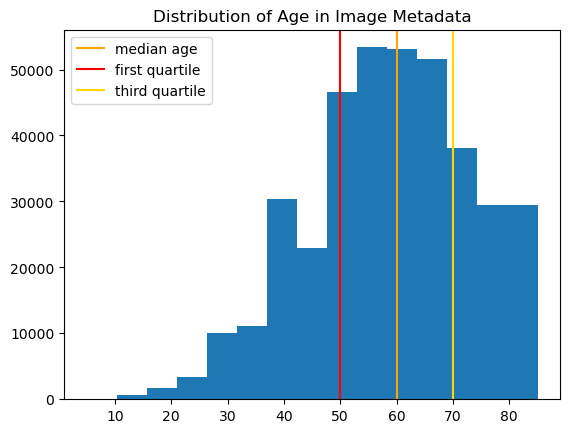

In [7]:
plt.hist(metadata_df.age_approx, bins = 15)
plt.axvline(metadata_df.age_approx.median(), color = 'orange', label = "median age")
plt.axvline(metadata_df.age_approx.quantile(.25), color = 'red', label = "first quartile")
plt.axvline(metadata_df.age_approx.quantile(.75), color = 'gold', label = "third quartile")
plt.title('Distribution of Age in Image Metadata')
plt.legend()

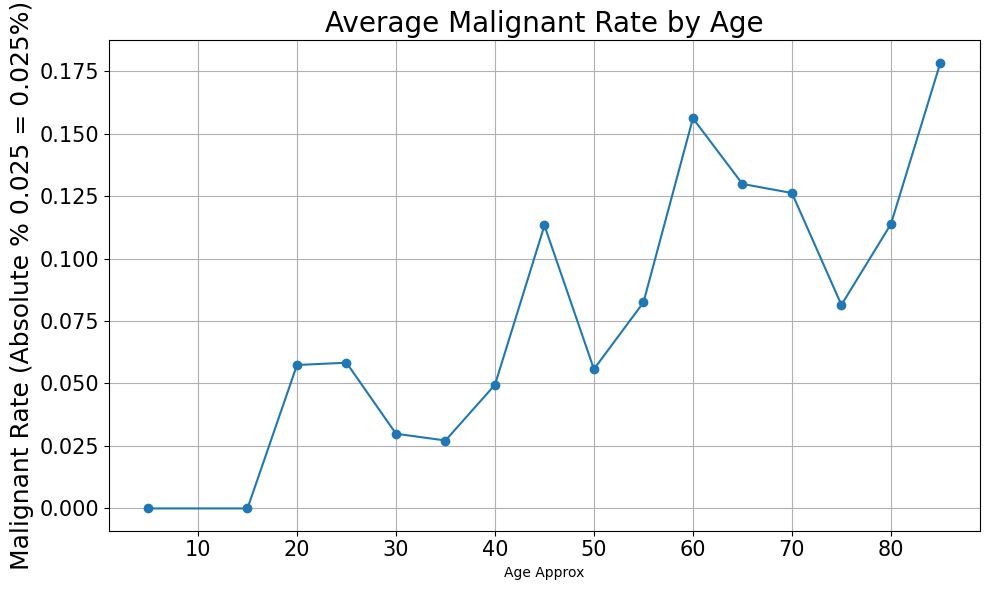

In [8]:
# Merge metadata and ground truth on isic_id
df = pd.merge(metadata_df, groundtruth_df, on='isic_id', how='inner')

# Drop rows where age is missing
df = df.dropna(subset=['age_approx'])

# Group by exact age and compute avg malignant rate
age_malignancy = df.groupby('age_approx')['malignant'].mean().reset_index()

# Plot
plt.figure(figsize=(10, 6))
plt.plot(age_malignancy['age_approx'], age_malignancy['malignant'] * 100, marker='o')
plt.xlabel('Age Approx')
plt.ylabel('Malignant Rate (Absolute % 0.025 = 0.025%)', fontsize = 18)
plt.title('Average Malignant Rate by Age', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True)
plt.tight_layout()

In [9]:
## creating is_60_plus categorical variable
df['is_60_plus'] = df.age_approx >= 60

---
#### EDA: Anatomical Location Distribution & Cancerous Image Rate

([0, 1, 2, 3, 4],
 [Text(0, 0, 'posterior torso'),
  Text(1, 0, 'lower extremity'),
  Text(2, 0, 'anterior torso'),
  Text(3, 0, 'upper extremity'),
  Text(4, 0, 'head/neck')])

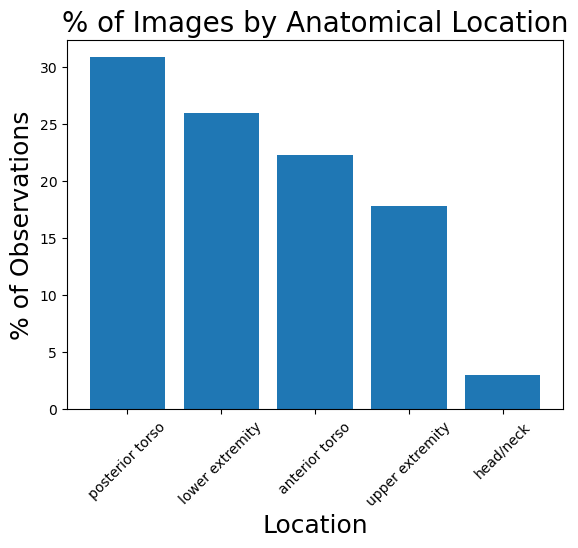

In [27]:
plot_df = 100 * df.anatom_site_general.value_counts(normalize= True).sort_values(ascending= False)
plt.bar(plot_df.index, plot_df)
plt.title('% of Images by Anatomical Location', fontsize = 20)
plt.xlabel('Location', fontsize = 18)
plt.ylabel('% of Observations', fontsize = 18)
plt.xticks(rotation = 45)

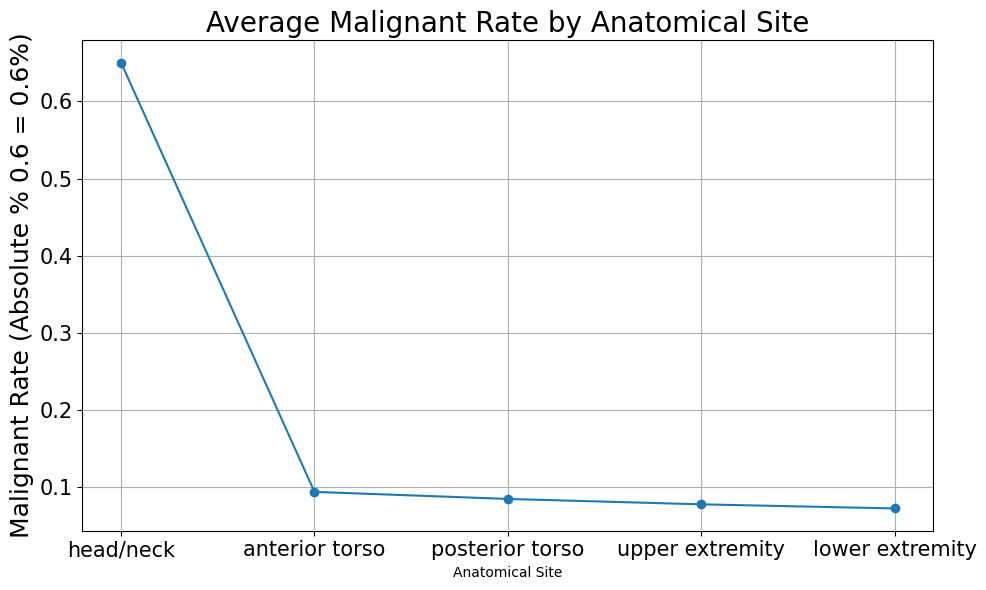

In [31]:
# Group by anatomical location group and compute avg malignant rate
anatom_malignancy = df.groupby('anatom_site_general')['malignant'].mean().reset_index().sort_values(by = 'malignant',ascending = False)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(anatom_malignancy['anatom_site_general'], anatom_malignancy['malignant'] * 100, marker='o')
plt.xlabel('Anatomical Site')
plt.ylabel('Malignant Rate (Absolute % 0.6 = 0.6%)', fontsize = 18)
plt.title('Average Malignant Rate by Anatomical Site', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True)
plt.tight_layout()

In [ ]:
# create categorical variable
df['is_head_neck'] = df.anatom_site_general == 'head/neck'

---
#### EDA: Sex Distribution & Cancerous Image Rate

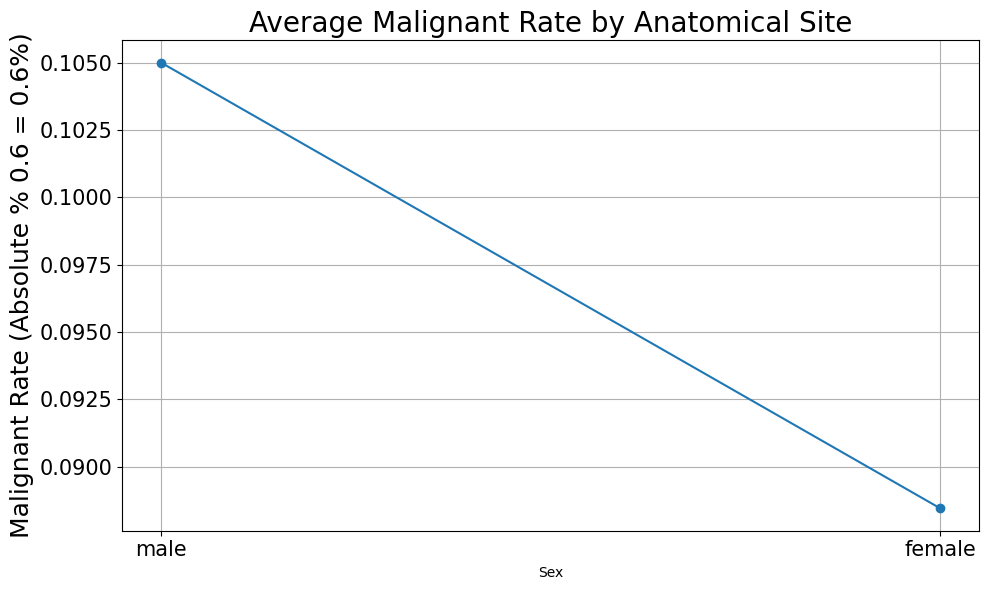

In [32]:
# Group by anatomical location group and compute avg malignant rate
sex_malignancy = df.groupby('sex')['malignant'].mean().reset_index().sort_values(by = 'malignant',ascending = False)

# Plot
plt.figure(figsize=(10, 6))
plt.plot(sex_malignancy['sex'], sex_malignancy['malignant'] * 100, marker='o')
plt.xlabel('Sex')
plt.ylabel('Malignant Rate (Absolute % 0.6 = 0.6%)', fontsize = 18)
plt.title('Average Malignant Rate by Anatomical Site', fontsize = 20)
plt.xticks(fontsize = 15)
plt.yticks(fontsize = 15)
plt.grid(True)
plt.tight_layout()